# Telecomunicaciones: identificar operadores ineficaces

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. 

Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

https://drive.google.com/drive/folders/1usOUc5lV098-gZJeOBBeTOZXiQBEyM4V?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

## Exploracion de datos

In [2]:
dataset = pd.read_csv('telecom_dataset_us.csv')
print(dataset.info())
print(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None
   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out

In [3]:
clients = pd.read_csv('telecom_clients_us.csv')
print(clients.info())
print(clients.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None
   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16


## tratamiento de los datos
- Cambiar el tipo de las columna de fecha
- Crear columna con el tiempo de espera de cada llamada
- Crear una fila para el mes en que ucurrio la llamada
- Crear columna la fecha de la primera llamada de cada operador
- rellenar la columna internal. 
- Eliminar filas donde falta operator_id

In [4]:
#cambiamos el tipo de datos a para las columnas de fecha
dataset['date'] = pd.to_datetime(dataset['date'])
clients['date_start'] = pd.to_datetime(clients['date_start'])


In [5]:
# se crea una columna con el tiempo de espera de cada llamada
dataset['wait_time'] = dataset['total_call_duration'] - dataset['call_duration']
dataset['month'] = dataset['date'].dt.month
dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_time,month
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,4,8
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,5,8
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,1,8
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,8,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,25,8


In [6]:
#creo un a columna con la primera llamada que atendio cada cliente
dataset['first_op_call'] = dataset.groupby('operator_id')['month'].transform('min')
dataset.sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_time,month,first_op_call
20364,167002,2019-10-23 00:00:00+03:00,in,False,NaN,True,4,0,1,1,10,NaN
25265,167125,2019-10-03 00:00:00+03:00,out,False,902742.0,False,24,4529,5029,500,10,9.0
21394,167031,2019-11-13 00:00:00+03:00,out,False,910520.0,True,1,0,53,53,11,9.0
35489,167532,2019-10-24 00:00:00+03:00,out,False,917852.0,True,5,0,64,64,10,9.0
24633,167112,2019-09-30 00:00:00+03:00,out,False,904014.0,True,21,0,237,237,9,9.0
51750,168336,2019-11-20 00:00:00+03:00,out,False,958418.0,False,12,1584,1685,101,11,11.0
13201,166782,2019-10-24 00:00:00+03:00,out,False,899250.0,True,2,0,104,104,10,8.0
375,166377,2019-10-20 00:00:00+03:00,in,False,NaN,True,1,0,66,66,10,NaN
41749,167888,2019-11-09 00:00:00+03:00,in,False,NaN,True,1,0,30,30,11,NaN
42726,167976,2019-11-25 00:00:00+03:00,in,False,934428.0,False,1,97,120,23,11,10.0


Dado que estamos buscando operadores ineficientes las filas donde no falta el operator_id no nos sirve.

Los datos de internal son mas los False que los True asi que  los faltantes los remplasare con False

In [7]:
# se rellena los datos faltantes de la columna 'internal'
dataset['internal'] = dataset['internal'].fillna('False')
# se eliminan las filas donde falta 'operator_id'
dataset = dataset.dropna().reset_index(drop=True)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              45730 non-null  int64                    
 1   date                 45730 non-null  datetime64[ns, UTC+03:00]
 2   direction            45730 non-null  object                   
 3   internal             45730 non-null  object                   
 4   operator_id          45730 non-null  float64                  
 5   is_missed_call       45730 non-null  bool                     
 6   calls_count          45730 non-null  int64                    
 7   call_duration        45730 non-null  int64                    
 8   total_call_duration  45730 non-null  int64                    
 9   wait_time            45730 non-null  int64                    
 10  month                45730 non-null  int32                    
 11  fi

In [9]:
print(dataset['date'].min())
print(dataset['date'].max())

2019-08-02 00:00:00+03:00
2019-11-28 00:00:00+03:00


## Llamadas perdidas

Filtramos el dataset para las llamadas de entrada.

Para las llamadas perdidas vamos a tomar en cuenta solo las llamadas de entrada se agruparan por operador y mes


{'whiskers': [<matplotlib.lines.Line2D at 0x257857a48c0>,
 'caps': [<matplotlib.lines.Line2D at 0x257857a4ec0>,
 'boxes': [<matplotlib.lines.Line2D at 0x257854d22a0>],
 'medians': [<matplotlib.lines.Line2D at 0x257857a54c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x257857a5790>],
 'means': []}

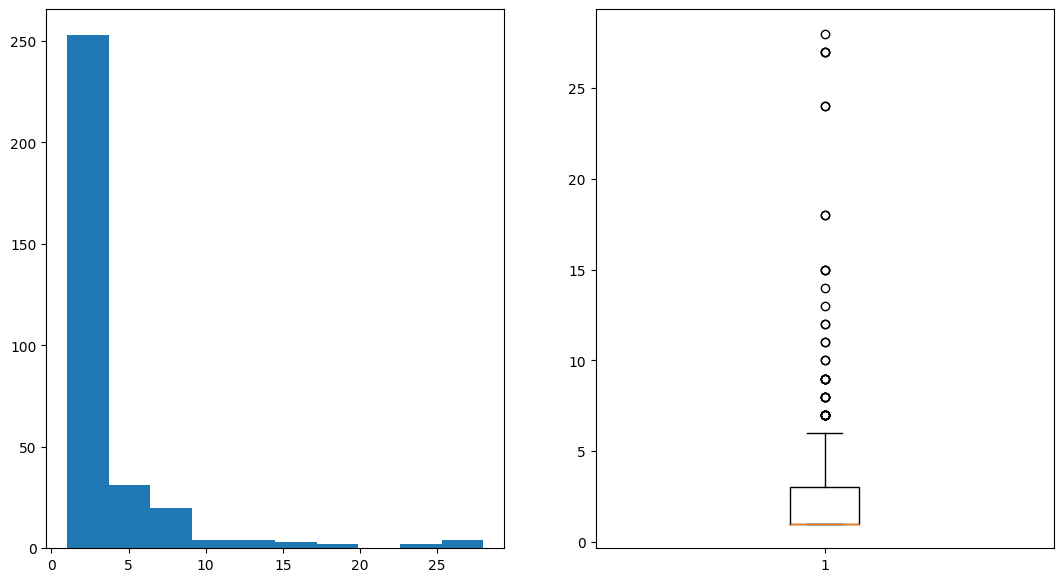

In [10]:
# filtro solo llamadas de entrada
dataset_in = dataset[dataset['direction'] == 'in']
#filtro para las llamadas perdidas
missed_calls = dataset_in[dataset_in['is_missed_call'] == True]

# se agrupa por operador y se cuentas las llamdas perdidas
missed_group = missed_calls.groupby(['operator_id', 'month'])['calls_count'].sum().reset_index()  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

ax1.hist(missed_group['calls_count'])
ax2.boxplot(missed_group['calls_count'])

Aquí podemos ver que la gran mayoría de los operadores tiene pocas llamadas perdidas al mes, son los que tiene muchas los que nos interesan.

Para calcular lo que se considera atípicamente alto usamos la misma formula que se usa para los diagramas de caja, para lo que necesitamos 2 datos el cuartil 3 (Q3) y el Interval intercuartílico (IQR) que es la distancia entre el cuartil 1 (Q1) y el cuartil 3, y seguimos la siguiente formula : Q3 + (1.5*IQR)

In [11]:
#calculamos los cuartiles
q1_mc = missed_group['calls_count'].quantile(0.25)
q2_mc = missed_group['calls_count'].quantile(0.50)
q3_mc = missed_group['calls_count'].quantile(0.75)
#calculamos rango intercuartil
iqr_mc = q3_mc - q1_mc
# largo del bigote superior del diagram de caja
atipic_mc = (q3_mc + (1.5 * iqr_mc)).round()
#cualquier valor por encima de este se considera atipico 
atipic_mc

np.float64(6.0)

El umbral es de 6 llamadas perdidas, enseguida se hace una lista con los que superaron este umbral. 33 operadores superan el umbral.

In [12]:
#operadores con muchas llamadas perdidas
op_missed_calls= missed_group[missed_group['calls_count']>atipic_mc]['operator_id'].drop_duplicates().reset_index(drop=True)
op_missed_calls

0     885876.0
1     885890.0
2     893804.0
3     905104.0
4     905862.0
5     906392.0
6     906412.0
7     908960.0
8     913938.0
9     913942.0
10    919166.0
11    919204.0
12    919206.0
13    919554.0
14    925922.0
15    931458.0
16    937860.0
17    937956.0
18    940588.0
19    940622.0
20    940624.0
21    940630.0
22    940652.0
23    940658.0
24    944216.0
25    944218.0
26    944220.0
27    944222.0
28    944226.0
29    948286.0
30    951508.0
31    952948.0
32    959312.0
Name: operator_id, dtype: float64

## Tiempo de espera

Para esta parte vamos a tomar en cuenta solo las llamadas que si se contestaron.

Aquí vamos a calcular el tiempo promedio de espera de cada operador por mes.


In [13]:
# primero eliminamos las filas de llamadas perdidas
dataset_te = dataset_in[dataset_in['is_missed_call'] == False]
operator_wt = dataset_te.groupby(['operator_id', 'month']).agg(
    calls = ('wait_time', 'count'),
    wait_time = ('wait_time', 'sum'),
    avg_time = ('wait_time', 'mean')
).reset_index()
operator_wt

,operator_id,month,calls,wait_time,avg_time
0,879896.0,8,15,449,29.933333
1,879896.0,9,6,129,21.500000
2,879896.0,10,2,41,20.500000
3,879898.0,8,11,169,15.363636
4,879898.0,9,20,549,27.450000
...,...,...,...,...,...
1451,971102.0,11,5,1370,274.000000
1452,971354.0,11,2,84,42.000000
1453,972412.0,11,1,25,25.000000
1454,972460.0,11,2,8,4.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x257858a9d60>,
 'caps': [<matplotlib.lines.Line2D at 0x257858aa300>,
 'boxes': [<matplotlib.lines.Line2D at 0x257858a9af0>],
 'medians': [<matplotlib.lines.Line2D at 0x257858aa8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x257858aab70>],
 'means': []}

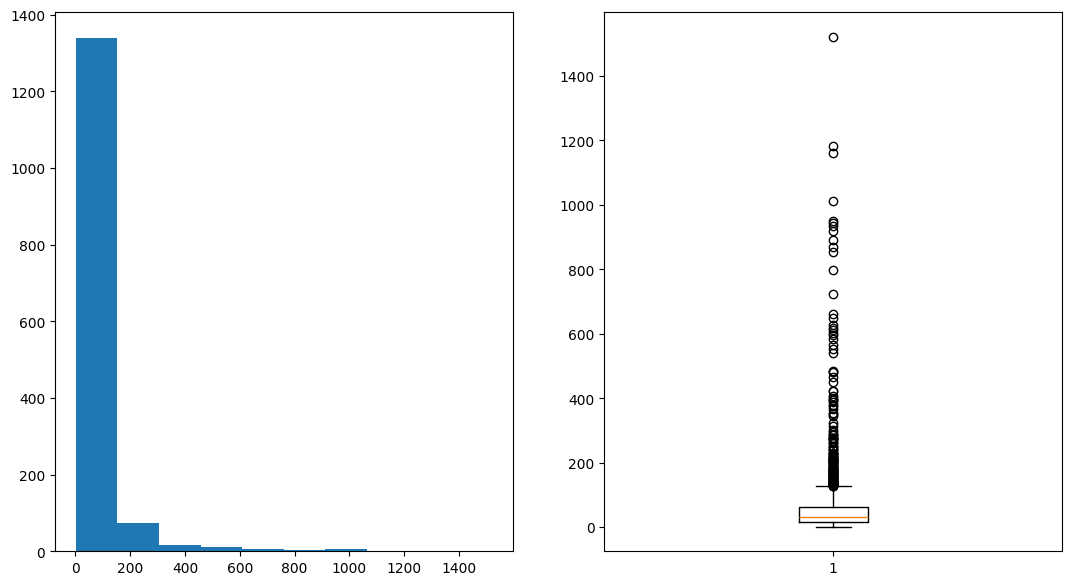

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

ax1.hist(operator_wt['avg_time'])
ax2.boxplot(operator_wt['avg_time'])

De nuevo podemos ver que la gran mayoría de los operadores si tienen poco tiempo de espera en promedio. 
Para identificar a los operadores menos eficientes seguimos el mismo proceso que con las llamadas perdidas.


In [15]:
# calculamos los cuartiles
q1_wt = operator_wt['avg_time'].quantile(0.25)
q2_wt = operator_wt['avg_time'].quantile(0.50)
q3_wt = operator_wt['avg_time'].quantile(0.75)
# calculamos rango intercuartil
iqr_wt = q3_wt - q1_wt
# largo del bigote superior del diagram de caja
atipic_wt = (q3_wt + (1.5 * iqr_wt)).round()
# cualquier valor por encima de este se considera atipico
atipic_wt

np.float64(127.0)

En este caso el umbral se fija en 127 segundos poco más de 3 minutos en promedio a lo largo de un mes. 91 empleados superaron este umbral en por lo menos una vez.

In [16]:
#operadores con largo tiempo de espera
op_long_wait_time = operator_wt[operator_wt['avg_time'] > atipic_wt]['operator_id'].drop_duplicates().reset_index(drop=True)
op_long_wait_time

0     882684.0
1     882686.0
2     882688.0
3     882690.0
4     885876.0
        ...   
86    962658.0
87    962902.0
88    969272.0
89    969294.0
90    971102.0
Name: operator_id, Length: 91, dtype: float64

## llamadas salientes

Se filtra el data set para para solo llamadas de salida, y tomar en cuenta solo los operadores que se dedican exclusivamente a hacer llamadas de salida.

In [17]:
operator_in = dataset_in['operator_id'].unique()

In [18]:
# filtramos por llamdas de salida, filtramos tambien la llmadas internas y descartamos el ultimo mes 
dataset_out = dataset[(dataset['direction'] == 'out')]
#dejamos los que solo hacen llamdas de salida
dataset_out = dataset_out[~dataset_out['operator_id'].isin(operator_in)]
dataset_out

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_time,month,first_op_call
7,166377,2019-08-06 00:00:00+03:00,out,False,881278.0,True,3,0,29,29,8,8.0
9,166377,2019-08-06 00:00:00+03:00,out,True,881278.0,True,2,0,5,5,8,8.0
346,166377,2019-10-21 00:00:00+03:00,out,False,881278.0,False,3,465,476,11,10,8.0
380,166377,2019-10-28 00:00:00+03:00,out,False,881278.0,True,1,0,5,5,10,8.0
427,166377,2019-11-07 00:00:00+03:00,out,True,881278.0,True,2,0,0,0,11,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
45715,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,False,3,419,478,59,11,11.0
45716,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89,89,11,11.0
45717,168603,2019-11-21 00:00:00+03:00,out,False,959118.0,True,1,0,10,10,11,11.0
45718,168603,2019-11-21 00:00:00+03:00,out,False,959118.0,False,5,338,423,85,11,11.0


Como en esta parte se necesita saber el umbral mas bajo vamos a filtrar a los operadores que tienen poco tiempo trabajando.

Después calculamos las llamadas de cada operador por mes.


In [19]:

#dado que necesitamor saber si hace pocas llamdas vamos a eliminar de la ecuacion a los operadores mas nuevos
dataset_out = dataset_out[dataset_out['first_op_call'] < 11]
#agrupoamospor operador, por mes y contamos las llamadas
operator_out = dataset_out.groupby(['operator_id', 'month'])['calls_count'].sum().reset_index()
operator_out.sort_values('calls_count')

,operator_id,month,calls_count
56,891192.0,8,1
380,941826.0,10,1
371,940842.0,10,1
372,940842.0,11,1
73,893700.0,9,1
...,...,...,...
394,945286.0,11,6450
306,929426.0,11,7205
307,929428.0,10,9251
308,929428.0,11,15321


{'whiskers': [<matplotlib.lines.Line2D at 0x25785997410>,
 'caps': [<matplotlib.lines.Line2D at 0x257859979b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x25785997080>],
 'medians': [<matplotlib.lines.Line2D at 0x25785997f50>],
 'fliers': [<matplotlib.lines.Line2D at 0x257859d0290>],
 'means': []}

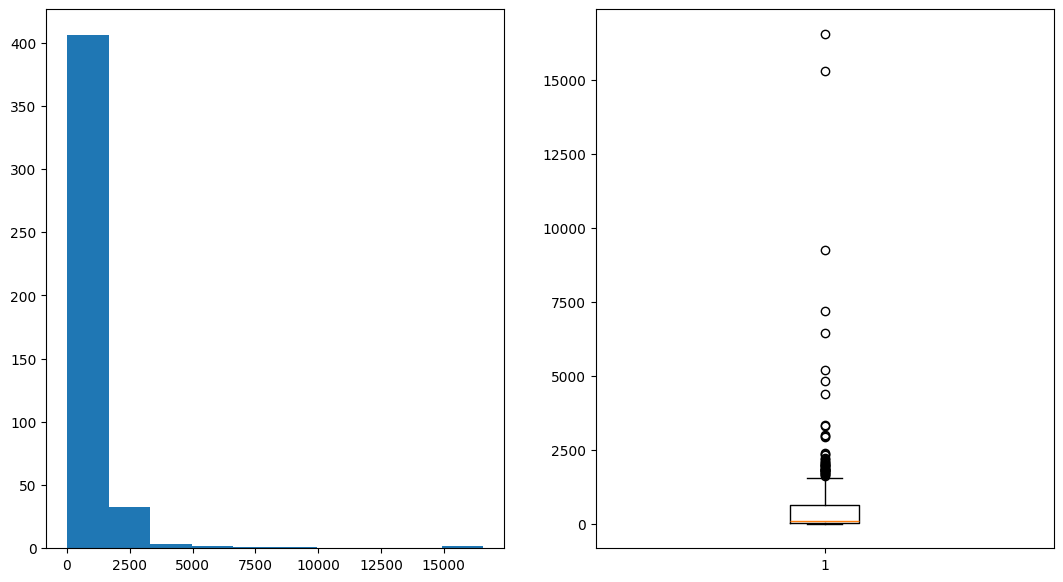

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

ax1.hist(operator_out['calls_count'])
ax2.boxplot(operator_out['calls_count'])

Aquí la verdad es que la mayor parte de los empleados son muy ineficientes.

In [21]:
# calculamos los cuartiles
q1_out = operator_out['calls_count'].quantile(0.25)
q2_out = operator_out['calls_count'].quantile(0.50)
q3_out = operator_out['calls_count'].quantile(0.75)
# calculamos rango intercuartil
iqr_out = q3_out - q1_out
# largo del bigote superior del diagram de caja
atipic_out = (q1_out - (1.5 * iqr_out)).round()
# cualquier valor por debajo de este lo consideraremos atipico
atipic_out
print(atipic_out)

-936.0


En este caso no hay datos atípicos como tal pues la mayoría hace muy pocas llamadas de salida por lo que usaremos el 10% de los operadores con menos llamadas de salida como umbral más bajo y filtraremos desde ahí.

In [32]:
umbral = operator_out['calls_count'].quantile(0.1)

#operador con pocas llamadas de salida
op_out_calls = operator_out[operator_out['calls_count'] < umbral]['operator_id'].drop_duplicates().reset_index(drop=True)
op_out_calls.unique()

array([883018., 883898., 890232., 890234., 891162., 891170., 891192.,
       891250., 891976., 892800., 893700., 899076., 905480., 905840.,
       907998., 910532., 914052., 914338., 914348., 917890., 919128.,
       919418., 924370., 928282., 928284., 932246., 936296., 937430.,
       937650., 937710., 937720., 937772., 937872., 940788., 940842.,
       941816., 941826., 945274., 947480., 947616.])

In [23]:
umbral

np.float64(3.0)

# Pruebas e hipotesis

In [24]:
bad_operators = pd.concat([op_missed_calls, op_long_wait_time]).drop_duplicates()
bad_operators

0     885876.0
1     885890.0
2     893804.0
3     905104.0
4     905862.0
        ...   
86    962658.0
87    962902.0
88    969272.0
89    969294.0
90    971102.0
Name: operator_id, Length: 100, dtype: float64

## Prueba de hipotesis llamas perdidas

- H0: las llamadas perdidas del grupo A y B promedio son son iguales
- HA: las llamadas perdidas del grupo A y B promedio son diferentes

Usaremos un valor de significancia alpha de 0.05

In [25]:
alpha = 0.05
# de divide el dataframe en dos grupos
#grupo B (ineficientes)
missed_group_B = missed_group[missed_group['operator_id'].isin(bad_operators)]
#grupo A (eficientes)
missed_group_A = missed_group[~missed_group['operator_id'].isin(bad_operators)]

# calculo las varianzas und ato queme servira en la prueba de hipotesis
print('varianza del grup A (eficientes)')
print(np.var(missed_group_A['calls_count']))
print('varianza el grupo B (ineficientes)')
print(np.var(missed_group_B['calls_count']))


varianza del grup A (eficientes)
1.0266655815972223
varianza el grupo B (ineficientes)
35.77029310646233


In [26]:
array_mA = np.array(missed_group_A['calls_count'])
array_mB = np.array(missed_group_B['calls_count'])

results_m = st.ttest_ind(array_mA, array_mB, equal_var=False)
print('valor de p', results_m.pvalue)
if results_m.pvalue < alpha:
    print('Rechazamos la hipotesis nula, los promedios de llamadas perdidas son significativamente diferentes')
else:
    print('No podemos rechazar la hipotesis nula')

valor de p 2.573523143661938e-11
Rechazamos la hipotesis nula, los promedios de llamadas perdidas son significativamente diferentes


## Prueba de hipotesis de tiempo de espera

- H0: El tiempo de espera promedio de los grupos A y B son iguales
- HA: El tiempo de espera promedio de los grupos A y B son diferentes

Usaremos un valor de significancia alpha de 0.05

In [27]:
wt_group_A = operator_wt[~operator_wt['operator_id'].isin(bad_operators)]
wt_group_B = operator_wt[operator_wt['operator_id'].isin(bad_operators)]
wt_group_B
#calculo varianza
print('varianza del grup A (eficientes)')
print(np.var(wt_group_A['avg_time']))
print('varianza el grupo B (ineficientes)')
print(np.var(wt_group_B['avg_time']))

varianza del grup A (eficientes)
614.5258993503643
varianza el grupo B (ineficientes)
55500.43762708888


In [28]:
array_wtA = np.array(wt_group_A['avg_time'])
array_wtB = np.array(wt_group_B['avg_time'])

results_wt = st.ttest_ind(array_wtA, array_wtB, equal_var=False)
print('valor de p', results_wt.pvalue)
if results_wt.pvalue < alpha:
    print('Rechazamos la hipotesis nula, los promedios de tiempos de espera son significativamente diferentes')
else:
    print('No podemos rechazar la hipotesis nula')

valor de p 1.1283303799250234e-27
Rechazamos la hipotesis nula, los promedios de tiempos de espera son significativamente diferentes


## pruebas de hipotesis de llamadas de salida

In [29]:
# divido el dataframe en dos
#grupo A (eficientes)
calls_out_A = operator_out[~operator_out['operator_id'].isin(op_out_calls)]
#grupo B (ineficientes)
calls_out_B = operator_out[operator_out['operator_id'].isin(op_out_calls)]

#calculamos varianza
print('varianza del grup A (eficientes)')
print(np.var(calls_out_A['calls_count']))
print('varianza el grupo B (ineficientes)')
print(np.var(calls_out_B['calls_count']))

varianza del grup A (eficientes)
2217443.4193628808
varianza el grupo B (ineficientes)
82007.27162629757


In [30]:
array_out_A = np.array(calls_out_A['calls_count'])
array_out_B = np.array(calls_out_B['calls_count'])

results_out = st.ttest_ind(array_out_A, array_out_B, equal_var=False)
print('valor de p:', results_out.pvalue)
if results_wt.pvalue < alpha:
    print('Rechazamos la hipotesis nula, los promedios de llamadas de salida son significativamente diferentes')
else:
    print('No podemos rechazar la hipotesis nula')

valor de p: 5.8488591839293995e-12
Rechazamos la hipotesis nula, los promedios de llamadas de salida son significativamente diferentes


In [35]:
#unimos las listas de empleados ineficientes
ineff_operators = pd.concat([bad_operators, op_out_calls]).drop_duplicates().reset_index(drop=True)
operators = dataset['operator_id'].drop_duplicates().reset_index(drop=True)

too_bad = bad_operators[bad_operators.isin(op_out_calls)].reset_index(drop=True)

bad_operators.unique()


array([885876., 885890., 893804., 905104., 905862., 906392., 906412.,
       908960., 913938., 913942., 919166., 919204., 919206., 919554.,
       925922., 931458., 937860., 937956., 940588., 940622., 940624.,
       940630., 940652., 940658., 944216., 944218., 944220., 944222.,
       944226., 948286., 951508., 952948., 959312., 882684., 882686.,
       882688., 882690., 887276., 890404., 891410., 892534., 895578.,
       898920., 899082., 902510., 902532., 905538., 906070., 906076.,
       906396., 906400., 906404., 906406., 906408., 906410., 906680.,
       908834., 908958., 909134., 911138., 911310., 913788., 916424.,
       917680., 917852., 918978., 918986., 919164., 919552., 919790.,
       919792., 919794., 921306., 921318., 921818., 923526., 925104.,
       937752., 937902., 938414., 938896., 939370., 939376., 939474.,
       939706., 939762., 940616., 940634., 940952., 944210., 944228.,
       944764., 954650., 954750., 958460., 962658., 962902., 969272.,
       969294., 9711

# Conclusiones
después de limpiar los datos, filtrar los usuarios nos quedamos con una lista y hacer pruebas de hipótesis para comprobar hicimos una lista con los empleados los empleados ineficientes.

se necesita capacitar mejor a los empleados que hacer llamadas de salida.

De los 1096 operadores 140 se pueden considerar ineficientes.

De los cuales 100 son por llamadas perdidas y tiempo de espera largos 40   son por pocas llamadas de salida.